# CNN Training

Target of this code is to train a CNN network to classify images of a digital readout to the digits 0 to 9. Additionally a category "NaN" is introduced, to mark images that are not amibiguous.

### Preparing the training
* First all libraries are loaded
    * It is assumed, that they are installed during the Python setup
* matplotlib is set to print the output inline in the jupyter notebook

In [1]:
########### Basic Parameters for Running: ################################
    
TFliteNamingAndVersion = "dig0901s1"   # Used for tflite Filename
Training_Percentage = 0.0              # 0.0 = Use all Images for Training
Epoch_Anz = 400

##########################################################################


import tensorflow as tf
import matplotlib.pyplot as plt
import glob
import numpy as np
from sklearn.utils import shuffle
from tensorflow.python import keras
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.layers import Dense, InputLayer, Conv2D, MaxPool2D, Flatten, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import History 
from tensorflow.keras.utils import to_categorical
from PIL import Image 

loss_ges = np.array([])
val_loss_ges = np.array([])

%matplotlib inline
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

### Load training data
* The data is expected in the "Input_dir"
* Inside subdirectories are expected from -1, 0, 1, ... 9 in which the pictures are sorted according to their values (=category)
* Picture size must be 20x32 with 3 color channels (RGB)
* The filename can be arbitrary

* The images are stored in the x_data[]
* The expected category for each image in the corresponding y_data[]

* The last step is a shuffle (from sklearn.utils) and split the data into training and validation data

In [2]:
Input_dir='ziffer_sortiert_resize'

files = glob.glob(Input_dir + '/*.*')
x_data = []
y_data = []

subdir = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "NaN"]

for aktsubdir in subdir:
    files = glob.glob(Input_dir + '/' + aktsubdir + '/*.jpg')
    if aktsubdir == "NaN":
        category = 10                # NaN does not work --> convert to 10
    else:
        category = aktsubdir
    for aktfile in files:
        test_image = Image.open(aktfile)
        test_image = np.array(test_image, dtype="float32")
        x_data.append(test_image)
        y_data.append(np.array([category]))

x_data = np.array(x_data)
y_data = np.array(y_data)
y_data = to_categorical(y_data, 11)
print(x_data.shape)
print(y_data.shape)

x_data, y_data = shuffle(x_data, y_data)

if (Training_Percentage > 0):
    X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=Training_Percentage)
else:
    X_train = x_data
    y_train = y_data

(1208, 32, 20, 3)
(1208, 11)


### Define the model

The layout of the network ist a typcial CNN network with alternating **Conv2D** and **MaxPool2D** layers. Finished after **flattening** with additional **Dense** layer.

#### Important
* Shape of the input layer: (32, 20, 3)
* Number of output layers: 11
* As loss function "categorical_crossentropy" is choosen, as it is a categories task

In [3]:
model = Sequential()
model.add(BatchNormalization(input_shape=(32,20,3)))
model.add(Conv2D(32, (3, 3), padding='same', activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(256,activation="relu"))
model.add(Dense(11, activation = "softmax"))
model.summary()

model.compile(loss=keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.Adadelta(learning_rate=1.0, rho=0.95), metrics = ["accuracy"])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 32, 20, 3)         12        
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 20, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 10, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 10, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 5, 64)          36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 2, 64)          0

# Training
The input pictures are randomly scattered for brightness, pixel shift variations and rotation angle. This is implemented with a ImageDataGenerator.


In [4]:
Batch_Size = 4
Shift_Range = 1
Brightness_Range = 0.3
Rotation_Angle = 10
ZoomRange = 0.4

datagen = ImageDataGenerator(width_shift_range=[-Shift_Range,Shift_Range], 
                             height_shift_range=[-Shift_Range,Shift_Range],
                             brightness_range=[1-Brightness_Range,1+Brightness_Range],
                             zoom_range=[1-ZoomRange, 1+ZoomRange],
                             rotation_range=Rotation_Angle)

if (Training_Percentage > 0):
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size)
    validation_iterator = datagen.flow(X_test, y_test, batch_size=Batch_Size)
    history = model.fit(train_iterator, validation_data = validation_iterator, epochs = Epoch_Anz)
else:
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size)
    history = model.fit(train_iterator, epochs = Epoch_Anz)



Epoch 1/400
302/302 [==============================] - 3s 7ms/step - loss: 2.1822 - accuracy: 0.3346
Epoch 2/400
302/302 [==============================] - 2s 7ms/step - loss: 1.3185 - accuracy: 0.6004
Epoch 3/400
302/302 [==============================] - 2s 6ms/step - loss: 0.8301 - accuracy: 0.7218
Epoch 4/400
302/302 [==============================] - 2s 6ms/step - loss: 0.7435 - accuracy: 0.7696
Epoch 5/400
302/302 [==============================] - 2s 6ms/step - loss: 0.6106 - accuracy: 0.8037
Epoch 6/400
302/302 [==============================] - 2s 6ms/step - loss: 0.5296 - accuracy: 0.8204
Epoch 7/400
302/302 [==============================] - 2s 6ms/step - loss: 0.5206 - accuracy: 0.8484
Epoch 8/400
302/302 [==============================] - 2s 6ms/step - loss: 0.4418 - accuracy: 0.8568
Epoch 9/400
302/302 [==============================] - 2s 7ms/step - loss: 0.3775 - accuracy: 0.8929
Epoch 10/400
302/302 [==============================] - 2s 8ms/step - loss: 0.3807 - accura

302/302 [==============================] - 2s 8ms/step - loss: 0.0771 - accuracy: 0.9824
Epoch 80/400
302/302 [==============================] - 3s 8ms/step - loss: 0.0736 - accuracy: 0.9749
Epoch 81/400
302/302 [==============================] - 2s 8ms/step - loss: 0.0560 - accuracy: 0.9749
Epoch 82/400
302/302 [==============================] - 3s 9ms/step - loss: 0.0941 - accuracy: 0.9821
Epoch 83/400
302/302 [==============================] - 3s 9ms/step - loss: 0.0348 - accuracy: 0.9907: 0s - loss: 0.0292 - accuracy: 0.99 - ETA: 0s - loss: 0.0298 - ac
Epoch 84/400
302/302 [==============================] - 3s 8ms/step - loss: 0.0770 - accuracy: 0.9833: 1s
Epoch 85/400
302/302 [==============================] - 3s 10ms/step - loss: 0.0952 - accuracy: 0.9765
Epoch 86/400
302/302 [==============================] - 3s 9ms/step - loss: 0.0519 - accuracy: 0.9813: 1s - los - ETA
Epoch 87/400
302/302 [==============================] - 3s 10ms/step - loss: 0.0747 - accuracy: 0.9825
Epoch 8

302/302 [==============================] - 3s 9ms/step - loss: 0.0329 - accuracy: 0.9902
Epoch 156/400
302/302 [==============================] - 3s 10ms/step - loss: 0.0427 - accuracy: 0.9888
Epoch 157/400
302/302 [==============================] - 3s 9ms/step - loss: 0.0706 - accuracy: 0.9844
Epoch 158/400
302/302 [==============================] - 3s 10ms/step - loss: 0.0694 - accuracy: 0.9849
Epoch 159/400
302/302 [==============================] - 3s 10ms/step - loss: 0.0251 - accuracy: 0.9916 0s
Epoch 160/400
302/302 [==============================] - 3s 9ms/step - loss: 0.0665 - accuracy: 0.9776
Epoch 161/400
302/302 [==============================] - 3s 10ms/step - loss: 0.0206 - accuracy: 0.9926
Epoch 162/400
302/302 [==============================] - 3s 9ms/step - loss: 0.0680 - accuracy: 0.9822
Epoch 163/400
302/302 [==============================] - 3s 10ms/step - loss: 0.0423 - accuracy: 0.9881
Epoch 164/400
302/302 [==============================] - 3s 9ms/step - loss: 0.

302/302 [==============================] - 3s 10ms/step - loss: 0.0585 - accuracy: 0.9881
Epoch 231/400
302/302 [==============================] - 3s 10ms/step - loss: 0.0394 - accuracy: 0.9884
Epoch 232/400
302/302 [==============================] - 3s 10ms/step - loss: 0.0558 - accuracy: 0.9826 0s - loss: 0.0562 - accuracy: 0.
Epoch 233/400
302/302 [==============================] - 3s 11ms/step - loss: 0.0363 - accuracy: 0.9904
Epoch 234/400
302/302 [==============================] - 3s 11ms/step - loss: 0.0234 - accuracy: 0.9936
Epoch 235/400
302/302 [==============================] - 3s 10ms/step - loss: 0.0514 - accuracy: 0.9910
Epoch 236/400
302/302 [==============================] - 3s 11ms/step - loss: 0.0246 - accuracy: 0.9934
Epoch 237/400
302/302 [==============================] - 3s 11ms/step - loss: 0.0407 - accuracy: 0.9884
Epoch 238/400
302/302 [==============================] - 3s 10ms/step - loss: 0.0249 - accuracy: 0.9964
Epoch 239/400
302/302 [======================

302/302 [==============================] - 3s 10ms/step - loss: 0.0303 - accuracy: 0.9910
Epoch 307/400
302/302 [==============================] - 3s 10ms/step - loss: 0.0216 - accuracy: 0.9916
Epoch 308/400
302/302 [==============================] - 3s 9ms/step - loss: 0.0074 - accuracy: 0.9973
Epoch 309/400
302/302 [==============================] - 3s 10ms/step - loss: 0.0201 - accuracy: 0.9951
Epoch 310/400
302/302 [==============================] - 3s 10ms/step - loss: 0.0236 - accuracy: 0.9921 0s - loss: 0.0237 - accuracy: 0.99
Epoch 311/400
302/302 [==============================] - 3s 10ms/step - loss: 0.0280 - accuracy: 0.9946
Epoch 312/400
302/302 [==============================] - 3s 10ms/step - loss: 0.0197 - accuracy: 0.9933
Epoch 313/400
302/302 [==============================] - ETA: 0s - loss: 0.0419 - accuracy: 0.9921 ETA: 0s - loss: 0 - 3s 10ms/step - loss: 0.0418 - accuracy: 0.9921
Epoch 314/400
302/302 [==============================] - 3s 10ms/step - loss: 0.0729 -

302/302 [==============================] - 2s 7ms/step - loss: 0.0521 - accuracy: 0.9896
Epoch 383/400
302/302 [==============================] - 2s 7ms/step - loss: 0.0229 - accuracy: 0.9944
Epoch 384/400
302/302 [==============================] - 2s 7ms/step - loss: 0.0218 - accuracy: 0.9909
Epoch 385/400
302/302 [==============================] - 2s 7ms/step - loss: 0.0098 - accuracy: 0.9958
Epoch 386/400
302/302 [==============================] - 2s 7ms/step - loss: 0.0148 - accuracy: 0.9972
Epoch 387/400
302/302 [==============================] - 2s 8ms/step - loss: 0.0059 - accuracy: 0.9975
Epoch 388/400
302/302 [==============================] - 2s 7ms/step - loss: 0.0303 - accuracy: 0.9921
Epoch 389/400
302/302 [==============================] - 2s 7ms/step - loss: 0.0283 - accuracy: 0.9940
Epoch 390/400
302/302 [==============================] - 2s 7ms/step - loss: 0.0284 - accuracy: 0.9901
Epoch 391/400
302/302 [==============================] - 2s 7ms/step - loss: 0.0468 - a

### Learing result
 
* Visualization of the training and validation results

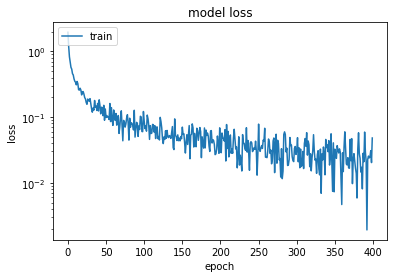

In [5]:
loss_ges = np.append(loss_ges, history.history['loss'])
plt.semilogy(history.history['loss'])

if (Training_Percentage > 0):
    val_loss_ges = np.append(val_loss_ges, history.history['val_loss'])
    plt.semilogy(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','eval'], loc='upper left')
plt.show()

### Check the model by hand

* The following code uses the trained model to check the deviation for each picture.
* x-axis walks through each pixel, y-axis shows the result

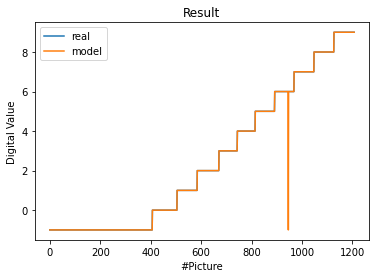

In [6]:
Input_dir='ziffer_sortiert_resize'
subdir = ["NaN", "0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
res = []

for aktsubdir in subdir:
    files = glob.glob(Input_dir + '/' + aktsubdir + '\*.jpg')
    if aktsubdir == "NaN":
        zw1 = -1
    else:
        zw1 = int(aktsubdir)
    for aktfile in files:
        test_image = Image.open(aktfile)
        test_image = np.array(test_image, dtype="float32")
        img = np.reshape(test_image,[1,32,20,3])
        classes = np.argmax(model.predict(img), axis=-1)
        classes = classes[0]
        if classes == 10: 
            classes = -1
        zw2 = classes
        zw3 = zw2 - zw1
        res.append(np.array([zw1, zw2, zw3]))

res = np.asarray(res)


plt.plot(res[:,0])
plt.plot(res[:,1])
plt.title('Result')
plt.ylabel('Digital Value')
plt.xlabel('#Picture')
plt.legend(['real','model'], loc='upper left')
plt.show()

### Save the model

* Save the model to the file with the "h5" file format

In [7]:
FileName = TFliteNamingAndVersion

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open(FileName + ".tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Muell\AppData\Local\Temp\tmpx_oanzg9\assets


766432

In [8]:
FileName = TFliteNamingAndVersion + "q"

import tensorflow as tf

def representative_dataset():
    for _ in range(500):
      data = np.random.rand(1, 32, 20, 3) * 255
      yield [data.astype(np.float32)]
        
converter2 = tf.lite.TFLiteConverter.from_keras_model(model)
converter2.representative_dataset = representative_dataset
converter2.optimizations = [tf.lite.Optimize.DEFAULT]
converter2.representative_dataset = representative_dataset
tflite_quant_model = converter2.convert()

open(FileName + ".tflite", "wb").write(tflite_quant_model)

INFO:tensorflow:Assets written to: C:\Users\Muell\AppData\Local\Temp\tmpn_4_599k\assets


INFO:tensorflow:Assets written to: C:\Users\Muell\AppData\Local\Temp\tmpn_4_599k\assets


203200

### Check each image for expected and deviation
* setting the switch "only_deviation = true" will only print the images for which the classification and the CNN-result deviates

The output contains the following information:

| Filename      | Expected Category           | Predicted Category        |
|------------- |:-----------------------------:|--------------|
| ziffer_sortiert_resize_NaN/5\Ziffer_4_0034.jpg | 4  | -1 |


In [9]:
Input_dir='ziffer_sortiert_resize'
only_deviation = True

subdir = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "NaN"]

for aktsubdir in subdir:
    files = glob.glob(Input_dir + '/' + aktsubdir + '\*.jpg')
    expected_class = aktsubdir
    for aktfile in files:
        test_image = Image.open(aktfile)
        test_image = np.array(test_image, dtype="float32")
        img = np.reshape(test_image,[1,32,20,3])
        classes = np.argmax(model.predict(img), axis=-1)
        classes = classes[0]
        if classes == 10: 
            classes = "NaN"
        if only_deviation == True:
            if str(classes) != str(expected_class):
                print(aktfile + " " + aktsubdir +  " " + str(classes))
        else:
            print(aktfile + " " + aktsubdir +  " " + str(classes))


ziffer_sortiert_resize/6\D8_2020-08-19_20-22-27.jpg 6 NaN


Checking the images shows, that this are border line images, which can be interpreted as a good digit or a faulty one.